# Scalable K-means++

## Outline of Background

1. ***K*-means** remains one of the most popular data processing algorithms. However a proper initialization is crucial for reciveing successful results. 

2. ***K*-means++** algorithm achived the goal of finding proper initialization with downside of its inherent sequentical nature, which limits its efficiency ( *O(n)* ) and applicability to big massive datasets.

3. The paper *Scalable* proposed the ***k*-means||** algorithm with efficiency ( *O(log n)* ), which forms ***k*-means++** in both sequential and parallel settings.

## Algorithm / Pseudocode

### Notations

Let $X =\{x_1,...x_n\}$ be the set of points in $d$-dimensional Euclidean space, and let $k$ be a positive integer specifying the number of clusters. Let ||$x_i$ - $x_j$ || denote the Euclidean distance between $x_i$ and $x_j$. For a point $x$ and a subset $Y \subseteq X$ of points, the distance is defined as $d(x,Y) = min_{y \in Y} ||x - y||$. For a subset $Y \subseteq X$ of points, let its \text{centroid} be given by
\begin{equation*}
\begin{split}
    \text{centroid}(Y) = \frac{1}{|Y|}\sum_{y \in Y} y
\end{split}
\end{equation*}
Let $C =\{c_1,...c_k\}$ be the set of points and let $Y \subseteq X$. We define the cost of $Y$ with respect to $C$ as
\begin{equation*}
\begin{split}
    \phi_Y(C) = \sum_{y \in Y} d^2(y,C) = \sum_{y \in Y} \min_{i=1,...,k}||y-c_i||^2
\end{split}
\end{equation*}


### $k$-means++($k$) initialization
1. $C \leftarrow$ sample a point uniformlt at random from $X$ 
2. **while** $|C|<k$ **do**
  - Sample $x \in X$ with probability $\frac{d^2(x,C)}{\phi_X(C)}$
  - $C \leftarrow C \cup \{x\}$ 
3. **end while**

### $k$-means||($k,l$) initialization
1. $C \leftarrow$ sample a point uniformly at random from $X$ 
2. $\psi \leftarrow \phi_X(C)$
3. **for** $O$(log$\psi$) times **do**
  - $C' \leftarrow$ sample each point $x \in X$ independently with probability $p_x = \frac{l \cdot d^2(x,C)}{\phi_X(C)}$	
  - $C \leftarrow C \cup C'$ 
4. **end for** 
5. For $x \in C$, set $w_x$ to be the number of points in $X$ closer to $x$ than any point in $C$ 
6. Recluster the weighted points in $C$ into $k$ clusters

## Draft of unit test

**Will verify the code correctness using following tests:**

1. Test the Cost function using examples in terms of:
  - non-negative
  - data = c
  - the size of c 
2. Test Sampling Probability function using examples in terms of: 
  - 0 <= Pi <= 1
  - sum = 1
3. Test K Means Plus Plus Parallel Probability function using examples in terms of: 
  - feasiblility
  - _labels attributes

## Data simulation

Simulating sample data from three bivariate normal distribution.

\begin{eqnarray*}
\begin{pmatrix}x_{1}\\
x_{2}
\end{pmatrix} & \sim & N_2\left(\left(\begin{array}{c}
0\\
1
\end{array}\right),\left(\begin{array}{ccc}
1 & 0.5\\
0 & 2
\end{array}\right)\right)\\
\begin{pmatrix}y_{1}\\
y_{2}
\end{pmatrix} & \sim & N_2\left(\left(\begin{array}{c}
3\\
7
\end{array}\right),\left(\begin{array}{ccc}
1 & 0.33\\
0.33 & 1
\end{array}\right)\right)\\
\begin{pmatrix}z_{1}\\
z_{2}
\end{pmatrix} & \sim & N_2\left(\left(\begin{array}{c}
-8\\
2
\end{array}\right),\left(\begin{array}{ccc}
2 & 0.66\\
0.66 & 2
\end{array}\right)\right)\\
\end{eqnarray*}



In [5]:
# Prepare
#!/usr/bin/python
from __future__ import division
import os
import sys
import glob
import random
import sklearn
import sklearn.cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Subplot
%matplotlib inline
plt.style.use('ggplot')

In [6]:
# Simulated "Real" Data Set
class SimulatedData:
    def __init__(self, n, data):
        self.data = data
        self.n = n      

    def DataSimulation(n):
        mean1 = np.array([0, 1])
        cov1 = np.array([[1, 0.5], [0.5, 2]])
        
        mean2 = np.array([3, 7])
        cov2 = np.array([[1, 0.33], [0.33, 1]])
        
        mean3 = np.array([-8, 2])
        cov3 = np.array([[2, 0.66], [0.66, 2]])
        
        tmp = np.vstack((np.random.multivariate_normal(mean1, cov1, n),
                          np.random.multivariate_normal(mean2, cov2, n),
                          np.random.multivariate_normal(mean3, cov3, n)))
        data = tmp[np.random.choice(range(3*n),size = 3*n, replace=False),]
        return data 

    def AsDataFrame(data):
        df = pd.DataFrame(data,columns=["X","Y"])
        return df

In [7]:
data = SimulatedData.DataSimulation(5)
data

array([[ 0.30125523,  1.13740308],
       [ 3.94469757,  7.06166959],
       [-7.32758509,  2.34132682],
       [ 2.47315557,  6.17398732],
       [-8.15785728,  0.7978464 ],
       [ 0.16858452,  1.03390761],
       [-0.72344158, -0.40448287],
       [-6.11342914,  0.70940116],
       [ 0.54442396,  2.4368663 ],
       [ 5.88241601,  8.33271191],
       [ 0.28952043,  3.92123748],
       [-7.33013152,  2.07012541],
       [ 1.82897483,  5.24025155],
       [-5.00156359,  3.74180785],
       [ 3.19756733,  5.86732292]])

## K-Means || Code

### Navïe Version

In [8]:
class ScalableKMeansPP:
    def __init__(self, data, k, l):
        self.data = data
        self.k = k 
        self.l = l 

    def KMeansParallel(data, k, l):
        N = data.__len__()
        if k <= 0 or not(isinstance(k,int)) or l <= 0:
            sys.exit()
        # Then we start to Implement the algorithm
        # 1. Sample one point uniformly at random from X
        c = np.array(data[np.random.choice(range(N),1),])
        # 2. To Cost function
        phi = ScalableKMeansPP.CostFunction(c, data)
        # 3. Looping
        for i in range(np.ceil(np.log(phi)).astype(int)):
            cPrime = data[ScalableKMeansPP.SamplingProbability(c,data,l) > np.random.uniform(size = N),]
            c = np.concatenate((c, cPrime))
        # End looping
        # 7. For x in C, set w_x to be the number of pts closest to X
        cMini = [np.argmin(np.sum((c-pts)**2,axis=1)) for pts in data];
        closerPts = [cMini.count(i) for i in range(len(c))]
        weight = closerPts/np.sum(closerPts)
        # 8. Recluster the weighted points in C into k clusters
        allC = data[np.random.choice(range(len(c)),size=1,p=weight),]
        data_final = c
        for i in range(k-1):
            Probability = ScalableKMeansPP.SamplingProbability(allC,data_final,l) * weight
            # choose next centroid
            cPrimeFin = data[np.random.choice(range(len(c)), size=1, p=Probability/np.sum(Probability)),]
            allC = np.concatenate((allC,cPrimeFin))
        KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=allC, max_iter=500, tol=0.0001)
        KMeansPP.fit(data);
        return KMeansPP
    
    def SamplingProbability(c,data,l):
        cost = ScalableKMeansPP.CostFunction(c,data)
        return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])
    
    def CostFunction(c,data):
        return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data]) 

In [21]:
data = SimulatedData.DataSimulation(10000)
ScalableKMeansPP.KMeansParallel(data,3,6)

KMeans(copy_x=True,
    init=array([[-9.39515,  1.80964],
       [ 4.84508,  7.8357 ],
       [ 2.38973,  8.21814]]),
    max_iter=500, n_clusters=3, n_init=1, n_jobs=1,
    precompute_distances=True, random_state=None, tol=0.0001, verbose=0)

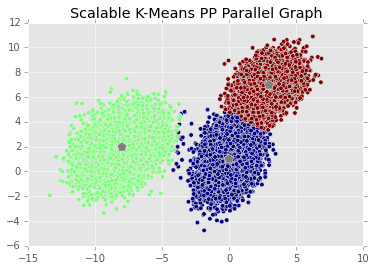

In [40]:
k = 3
KMeansPP = ScalableKMeansPP.KMeansParallel(data=data, k=k, l=2*k); # paper suggesting using l=2k
df = SimulatedData.AsDataFrame(data)
plt.scatter(df.X,df.Y,c=KMeansPP.labels_);
plt.scatter(KMeansPP.cluster_centers_[:,0],KMeansPP.cluster_centers_[:,1], c='grey', s=100, marker=(5,0));
plt.title("Scalable K-Means PP Parallel Graph");

## Algorithm Comparison

For algorithm comparison, I will using different sizes of same sample data to clustering using orginal k-means, k-means++, k-means||. Test their result and compare the efficiency.

We use "K-Means" and "K-Means++" methods from **sklearn.cluster.KMeans** package.

### K-Means

In [29]:
import timeit
data1 = SimulatedData.DataSimulation(100000)
start = timeit.timeit()
k = 3
KMeans = sklearn.cluster.KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, tol=0.0001)
KMeans.fit(data1);
end = timeit.timeit()
print(end - start)

0.003027081023901701


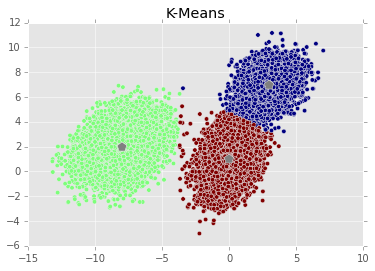

In [30]:
KMeans = sklearn.cluster.KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, tol=0.0001)
KMeans.fit(data);
df = SimulatedData.AsDataFrame(data)
plt.scatter(df.X,df.Y,c=KMeans.labels_);
plt.scatter(KMeans.cluster_centers_[:,0],KMeans.cluster_centers_[:,1], c='grey', s=100, marker=(5,0));
plt.title("K-Means");

### K-Means++

In [33]:
import timeit
data1 = SimulatedData.DataSimulation(100000)
start = timeit.timeit()
k = 3
KMeansPlusPlus = sklearn.cluster.KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=500, tol=0.0001)
KMeansPlusPlus.fit(data1);
end = timeit.timeit()
print(end - start)

-0.00046852201921865344


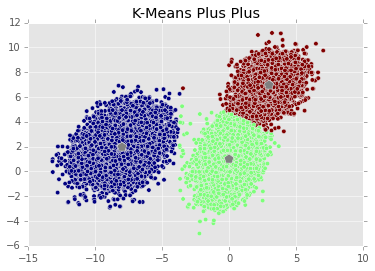

In [35]:
KMeansPlusPlus = sklearn.cluster.KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, tol=0.0001)
KMeansPlusPlus.fit(data);
df = SimulatedData.AsDataFrame(data)
plt.scatter(df.X,df.Y,c=KMeansPlusPlus.labels_);
plt.scatter(KMeansPlusPlus.cluster_centers_[:,0],KMeansPlusPlus.cluster_centers_[:,1], c='grey', s=100, marker=(5,0));
plt.title("K-Means Plus Plus");

From the result of timeit, we can concluded that K-Means++ is much efficienct than the base K-Means. However, it seems that the navïe version of Scalable K-Means++ are slower than K-Means++, or even the base K-Means. 

The reason would be, the package algorithms using parallel. I will try to optimization my code.

## Optimization Strategies

1. Using alternative method to replace inefficent code in Python
2. Will try on large datasets, if still take too long. Could try to use other languages to write the looping part

## Optimization:  Vectorized Version

In [36]:
class VectoredScalableKMeansPP(ScalableKMeansPP):
    def __init__(self, data, k, l):
        ScalableKMeansPP.__init__(self, data, k, l)

    def KMeansParallel(data, k, l):
        N = data.__len__()
        # 1. Sample one point uniformly at random from X
        c = data[np.random.choice(range(data.shape[0]),1), :]
        data2 = data[:,np.newaxis,:]
        # 2. To Cost function
        phi = ScalableKMeansPP.CostFunction(c, data)
        # 3. Looping
        for i in range(np.ceil(np.log(phi)).astype(int)):
            d2 = (data2 - c) ** 2
            distance = np.sum(d2, axis=2)
            cMini = np.zeros(distance.shape)
            cMini[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
            min_dist = distance[cMini == 1]
            phi = np.sum(min_dist)
            for i, cPrime in enumerate(data):
                Probability = l*min_dist[i]/phi
                u = np.random.uniform(0,1)
                if Probability >= u:
                    c = np.vstack([c, cPrime])
        # End looping
        # 7. For x in C, set w_x to be the number of pts closest to X
        d2 = (data2 - c) ** 2
        distance = np.sum(d2, axis=2)
        cMini = np.zeros(distance.shape)
        cMini[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
        weight = np.array([np.count_nonzero(cMini[:, i]) for i in range(c.shape[0])]).reshape(-1,1)
        # 8. Recluster the weighted points in C into k clusters
        allC = c[np.random.choice(range(c.shape[0]),1), :]
        data_final = c
        index = np.where(data_final==allC)[0]
        data_final = np.delete(data_final,index[0],axis=0)
        weight = np.delete(weight,index[0])
        for i in range(k-1):
            Probability = ScalableKMeansPP.SamplingProbability(allC,data_final,l) * weight
            # choose next centroid
            c = data_final[np.random.choice(range(data_final.shape[0]),size=1, p=Probability/np.sum(Probability)),]
            index = np.where(data_final==c)[0]
            allC = np.vstack([allC, c])
            #Remove the selected center and its corresponding weight
            data_final = np.delete(data_final,index[0],axis=0)
            weight = np.delete(weight,index[0])
        vKMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=allC, max_iter=500, tol=0.0001)
        vKMeansPP.fit(data)
        return vKMeansPP

In [37]:
data = SimulatedData.DataSimulation(1000)
VectoredScalableKMeansPP.KMeansParallel(data,3,6)

KMeans(copy_x=True,
    init=array([[  8.50610e-01,   1.11491e+00],
       [ -1.04880e+01,   8.50303e-03],
       [ -6.17235e+00,   5.31408e+00]]),
    max_iter=500, n_clusters=3, n_init=1, n_jobs=1,
    precompute_distances=True, random_state=None, tol=0.0001, verbose=0)

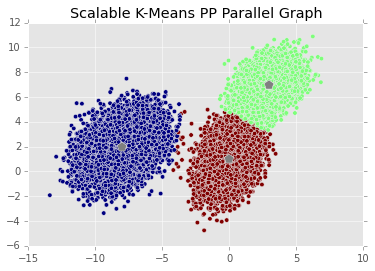

In [41]:
KMeansPP2 = VectoredScalableKMeansPP.KMeansParallel(data=data, k=k, l=2*k); 
df = SimulatedData.AsDataFrame(data)
plt.scatter(df.X,df.Y,c=KMeansPP2.labels_);
plt.scatter(KMeansPP2.cluster_centers_[:,0],KMeansPP2.cluster_centers_[:,1], c='grey', s=100, marker=(5,0));
plt.title("Scalable K-Means PP Parallel Graph");

## Efficiency Comparsion: Profiling

In [ ]:
! pip install --pre line-profiler &> /dev/null
! pip install psutil &> /dev/null
! pip install memory_profiler &> /dev/null

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f ScalableKMeansPP.KMeansParallel ScalableKMeansPP.KMeansParallel(data = data, k=3, l = 2*3)

In [ ]:
Timer unit: 1e-06 s

Total time: 13.3943 s
File: <ipython-input-125-d01bb3e3c9ef>
Function: KMeansParallel at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     7                                               def KMeansParallel(data, k, l):
     8         1            4      4.0      0.0          N = data.__len__()
     9         1            2      2.0      0.0          if k <= 0 or not(isinstance(k,int)) or l <= 0:
    10                                                       sys.exit()
    11                                                   # Then we start to Implement the algorithm
    12                                                   # 1. Sample one point uniformly at random from X
    13         1         3501   3501.0      0.0          c = np.array(data[np.random.choice(range(N),1),])
    14                                                   # 2. To Cost function
    15         1       270143 270143.0      2.0          phi = ScalableKMeansPP.CostFunction(c, data)
    16                                                   # 3. Looping
    17        16           56      3.5      0.0          for i in range(np.ceil(np.log(phi)).astype(int)):
    18        15     12559007 837267.1     93.8              cPrime = data[ScalableKMeansPP.SamplingProbability(c,data,l) > np.random.uniform(size = N),]
    19        15          127      8.5      0.0              c = np.concatenate((c, cPrime))
    20                                                   # End looping
    21                                                   # 7. For x in C, set w_x to be the number of pts closest to X
    22         1       369043 369043.0      2.8          cMini = [np.argmin(np.sum((c-pts)**2,axis=1)) for pts in data];
    23         1       174695 174695.0      1.3          closerPts = [cMini.count(i) for i in range(len(c))]
    24         1          114    114.0      0.0          weight = closerPts/np.sum(closerPts)
    25                                                   # 8. Recluster the weighted points in C into k clusters
    26         1          112    112.0      0.0          allC = data[np.random.choice(range(len(c)),size=1,p=weight),]
    27         1            1      1.0      0.0          data_final = c
    28         3            5      1.7      0.0          for i in range(k-1):
    29         2         3734   1867.0      0.0              Probability = ScalableKMeansPP.SamplingProbability(allC,data_final,l) * weight
    30                                                       # choose next centroid
    31         2          278    139.0      0.0              cPrimeFin = data[np.random.choice(range(len(c)), size=1, p=Probability/np.sum(Probability)),]
    32         2           13      6.5      0.0              allC = np.concatenate((allC,cPrimeFin))
    33         1           23     23.0      0.0          KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=allC, max_iter=500, tol=0.0001)
    34         1        13424  13424.0      0.1          KMeansPP.fit(data);
    35         1            2      2.0      0.0          return KMeansPP

In [ ]:
%lprun -f VectoredScalableKMeansPP.KMeansParallel VectoredScalableKMeansPP.KMeansParallel(data = data, k=3, l = 2*3)

In [ ]:
Timer unit: 1e-06 s

Total time: 3.66441 s
File: <ipython-input-114-00df5cba66a8>
Function: KMeansParallel at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     5                                               def KMeansParallel(data, k, l):
     6         1            7      7.0      0.0          N = data.__len__()
     7                                                   # 1. Sample one point uniformly at random from X
     8         1         3579   3579.0      0.1          c = data[np.random.choice(range(data.shape[0]),1), :]
     9         1            4      4.0      0.0          data2 = data[:,np.newaxis,:]
    10                                                   # 2. To Cost function
    11         1       264291 264291.0      7.2          phi = ScalableKMeansPP.CostFunction(c, data)
    12                                                   # 3. Looping
    13        16           49      3.1      0.0          for i in range(np.ceil(np.log(phi)).astype(int)):
    14        15       505753  33716.9     13.8              d2 = (data2 - c) ** 2
    15        15       254088  16939.2      6.9              distance = np.sum(d2, axis=2)
    16        15        36050   2403.3      1.0              cMini = np.zeros(distance.shape)
    17        15        86425   5761.7      2.4              cMini[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
    18        15        33310   2220.7      0.9              min_dist = distance[cMini == 1]
    19        15          796     53.1      0.0              phi = np.sum(min_dist)
    20    450015       577435      1.3     15.8              for i, cPrime in enumerate(data):
    21    450000       646465      1.4     17.6                  Probability = l*min_dist[i]/phi
    22    450000       597961      1.3     16.3                  u = np.random.uniform(0,1)
    23    450000       508532      1.1     13.9                  if Probability >= u:
    24        75         2341     31.2      0.1                      c = np.vstack([c, cPrime])
    25                                                   # End looping
    26                                                   # 7. For x in C, set w_x to be the number of pts closest to X
    27         1        67089  67089.0      1.8          d2 = (data2 - c) ** 2
    28         1        32498  32498.0      0.9          distance = np.sum(d2, axis=2)
    29         1         5074   5074.0      0.1          cMini = np.zeros(distance.shape)
    30         1         6751   6751.0      0.2          cMini[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
    31         1        15825  15825.0      0.4          weight = np.array([np.count_nonzero(cMini[:, i]) for i in range(c.shape[0])]).reshape(-1,1)
    32                                                   # 8. Recluster the weighted points in C into k clusters
    33         1           87     87.0      0.0          allC = c[np.random.choice(range(c.shape[0]),1), :]
    34         1            2      2.0      0.0          data_final = c
    35         1           16     16.0      0.0          index = np.where(data_final==allC)[0]
    36         1           48     48.0      0.0          data_final = np.delete(data_final,index[0],axis=0)
    37         1           32     32.0      0.0          weight = np.delete(weight,index[0])
    38         3            4      1.3      0.0          for i in range(k-1):
    39         2         2686   1343.0      0.1              Probability = ScalableKMeansPP.SamplingProbability(allC,data_final,l) * weight
    40                                                       # choose next centroid
    41         2          140     70.0      0.0              c = data_final[np.random.choice(range(data_final.shape[0]),size=1, p=Probability/np.sum(Probability)),]
    42         2           17      8.5      0.0              index = np.where(data_final==c)[0]
    43         2           43     21.5      0.0              allC = np.vstack([allC, c])
    44                                                       #Remove the selected center and its corresponding weight
    45         2           62     31.0      0.0              data_final = np.delete(data_final,index[0],axis=0)
    46         2           55     27.5      0.0              weight = np.delete(weight,index[0])
    47         1           20     20.0      0.0          vKMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=allC, max_iter=500, tol=0.0001)
    48         1        16874  16874.0      0.5          vKMeansPP.fit(data)
    49         1            3      3.0      0.0          return vKMeansPP

**By profiling, it is clearlt that Vectored KMeansParallel function is more than three times faster than the navie KMeansParallel function.**

In [ ]:
! ipython nbconvert --to latex ScalableKMeansPlusPlus.ipynb